# Global search using Lookup Table
## Synthetic model with 2 layers

In [1]:
%matplotlib widget

In [2]:
# Import libraries
import empymod
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0
from mpl_toolkits import mplot3d

import sys
sys.path.insert(1, '../src')

from PlotModel import PlotModelCond_2lay, Plot3Models_2lay, PlotErrorSpace
from EM1D import EMforward2lay, GlobalSearch, ErrorSpace

### 1. Define the synthetic model

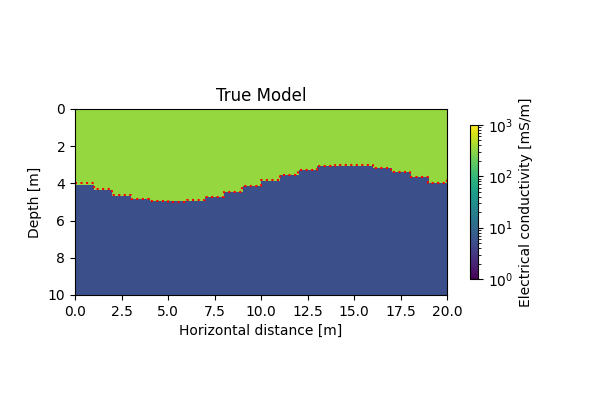

In [3]:
# Import the conductivities and thicknesses used to create the LU table

conds = np.load('../data/conds_samples.npy')
thick = np.load('../data/thick_samples.npy')

# parameters for the synthetic model

nlayer = 2 # number of layer
npos = 20 # number of sampling positions

sig_ini = [conds[42]+conds[3], conds[14]-conds[3]] # conductivities of the layers
sigmas = np.ones((npos, nlayer))*sig_ini # conductivity array

x = np.linspace(0, 20, npos) # Horizontal positions array
thk1 = np.ones_like(x)*4 + np.sin(2*np.pi*x)   # wave boundary for the layers

depths = np.zeros((npos, nlayer))
depths[:,1] = thk1 

PlotModelCond_2lay(sigmas, depths)
plt.title('True Model')
plt.show()

### 2. Create synthetic data to test the global search

In [4]:
# Create empty array for true model in each position
model = np.stack((sigmas[:,0], sigmas[:,1], depths[:,1]), axis=1)

# Create empty array for true data in each position
data_true=[]

# Simulate data in each position
for i in range(npos):
    data_true.append(EMforward2lay(sigmas[i][0], sigmas[i][1], depths[i][1], height = 0.10)) 
    
data_true = np.array(data_true)

### 3. Normalize data sets due to offset

In [5]:
LUT = np.load('../data/LookupTable2Layers.npy')

norm = np.array([4, 2, 1])

LUT_norm = LUT[:] * np.hstack([norm, norm, norm, norm, norm, norm])
data_true_norm = data_true[:] * np.hstack([norm, norm, norm, norm, norm, norm])

### 3. Perform global search in each position

In [6]:
model_est = model.copy()
model_est_Q = model.copy()

# Estimate with both Quadrature and In Phase
for p in range(npos):
    model_est[p] = GlobalSearch(LUT_norm, data_true_norm[p], conds, thick)
    
# Estimate using only Quadrature
for p in range(npos):
    model_est_Q[p] = GlobalSearch(LUT_norm[:,:9], data_true_norm[p,:9], conds, thick)

### 4. Plot Estimated model

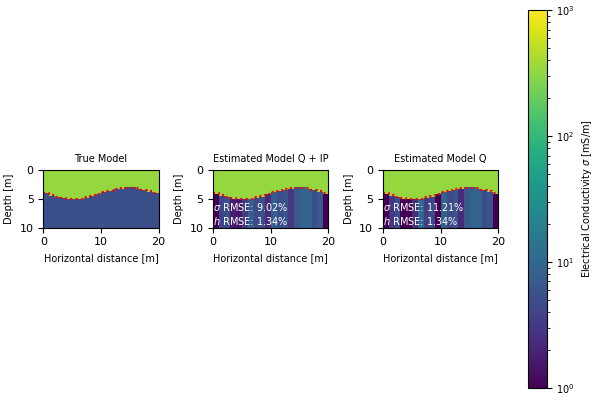

In [7]:
Plot3Models_2lay(model, model_est, model_est_Q, conds)
plt.show()

### 5. Check the error space in a specific position

In [8]:
# For example let's check the following position
pos = 10

# Simulate data for this position
data_est_pos = EMforward2lay(model_est[pos,0], model_est[pos,1], model_est[pos,2], height=0.1)
data_est_pos_norm = data_est_pos * np.hstack([norm, norm, norm, norm, norm, norm])

data_estQ_pos = EMforward2lay(model_est_Q[pos,0], model_est_Q[pos,1], model_est_Q[pos,2], height=0.1)
data_estQ_pos_norm = data_estQ_pos * np.hstack([norm, norm, norm, norm, norm, norm])

# Evaluate error space
err, models_err = ErrorSpace(LUT_norm, data_est_pos_norm, 0.1, conds, thick)
err_Q, models_err_Q = ErrorSpace(LUT_norm, data_estQ_pos_norm, 0.1, conds, thick)

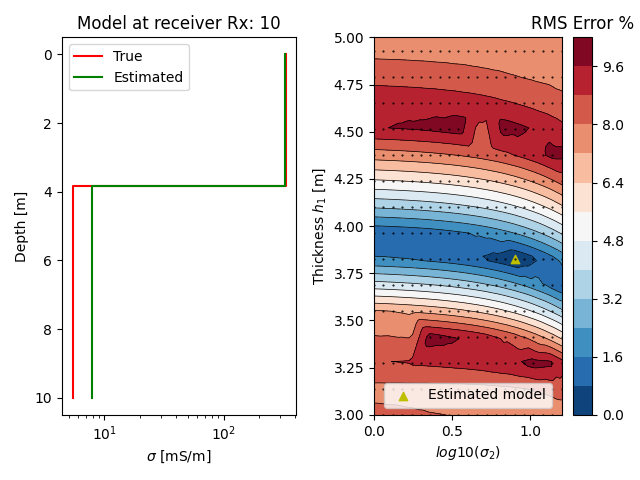

In [9]:
# Error space using Q + IP

PlotErrorSpace(model, model_est, pos, err, models_err)
plt.tight_layout()
plt.show()

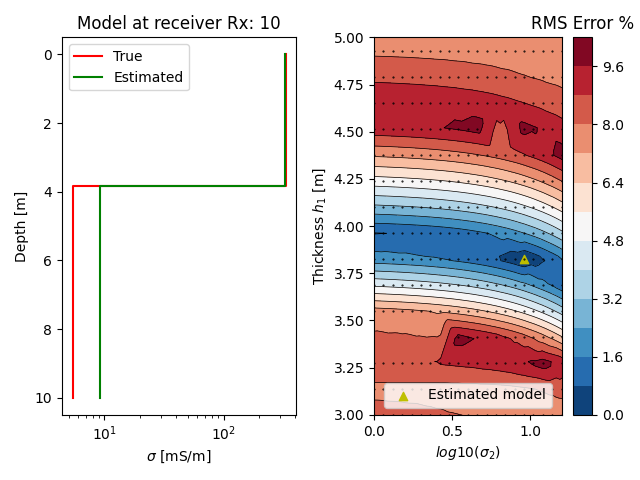

In [10]:
# Error space using Q 
PlotErrorSpace(model, model_est_Q, pos, err_Q, models_err_Q)
plt.tight_layout()
plt.show()

In [29]:
## Let's test the Global search with noise added to data

# Adding noise to data
error = 0.05

data_true_noise = data_true.copy()
data_true_noise *= (np.random.randn(np.size(data_true))*error).reshape(np.shape(data_true)) +1

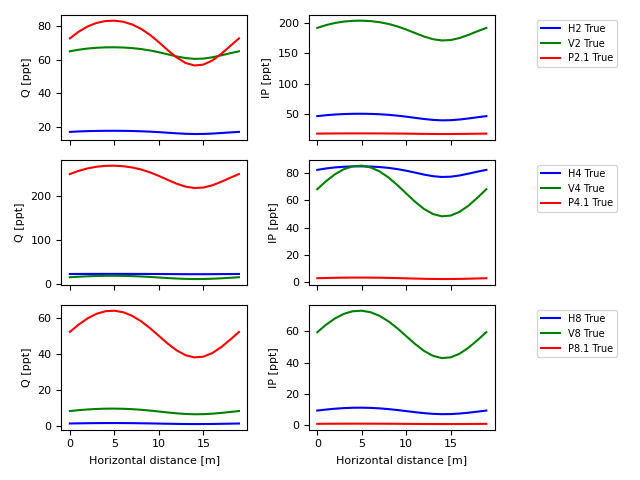

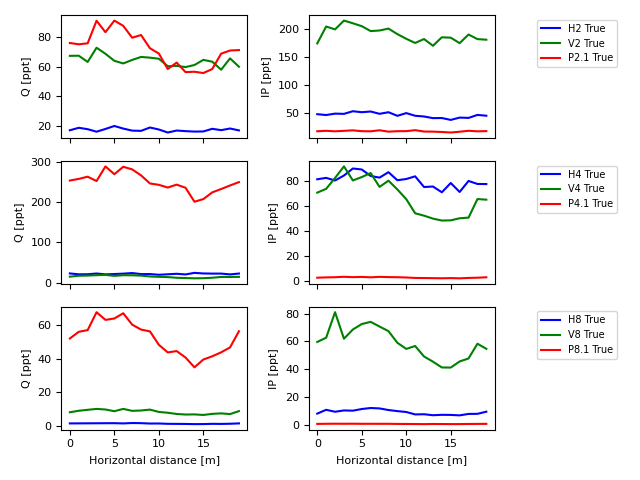

In [30]:
PlotData(data_true)
PlotData(data_true_noise)

In [31]:
data_true_norm_noise = data_true_noise[:] * np.hstack([norm, norm, norm, norm, norm, norm])

model_est_noise = model.copy()
model_est_Q_noise = model.copy()

# Estimate with both Quadrature and In Phase
for p in range(npos):
    model_est_noise[p] = GlobalSearch(LUT_norm, data_true_norm_noise[p], conds, thick)
    
# Estimate using only Quadrature
for p in range(npos):
    model_est_Q_noise[p] = GlobalSearch(LUT_norm[:,:9], data_true_norm_noise[p,:9], conds, thick)

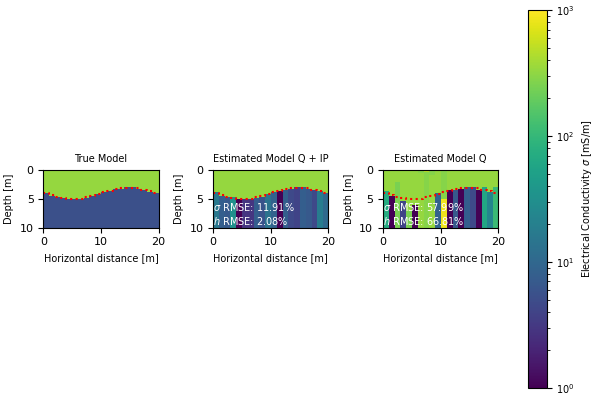

In [32]:
Plot3Models_2lay(model, model_est_noise, model_est_Q_noise, conds)
plt.show()

## Using ML

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2023-07-06 14:30:17.915210: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 14:30:18.230864: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-06 14:30:18.233143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 14:30:20.789134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [36]:
# Input variables conds and thicks must be in a single array X

x=[]
for c1 in conds:
    for c2 in conds:
        for t1 in thick:
            x.append([c1,c2,t1])
            
X = np.array(x)

# The lookup table is the output variables stored as array Y

# Y = f(X)

ModuleNotFoundError: No module named 'scikit'